<center><h1>Safe Driver Prediction</h1></center>
<center><h2>Capstone project by</h2></center>
<center><h2>Murali Mandayam</h2></center>
<center><h3>8th March 2019</h3></center>
<center><h3>www.thinkful.com</h3></center>


Data science has risen to prmoninence in the last decade due to its capabilities in predictive algorithms. While many business verticals value predictive algorithms using Data Science, insurance companies place a lot of importance as it helps them keeps premium low. Data is always been at the core of what insurance companies do analyzing data such as claims, what kind of a vehicle one drives, how many miles do they drive per day among other.
<br><br>
The data science field is gaining strength with improvements in technology, availability of statistical libraries to compute regression or classifications of data collected. Actuaries, the data scientists at insurance companies as they were called a decade ago, used to collate data from different sources and analyze the premium and claim data to identify fraudulent transactions that helped them keep the premiums low. If anything, data science technology of today has given far more tools to perform their analysis.
<br><br>
This Capstone project for Supervised Learning uses data from Kaggle (https://www.kaggle.com/mu202199/safe-driver-prediction). The data has a few ordinal, categorical data that needs to be parsed and categorized properly.
<br><br>
Our goal is to predict a binary outcome of 1, to indicate safe driver, or 0, to indicate that the drivers' data needs a review. We will also look at the continuous variables and fill in the missing data with the mean or median in order to not skew our results.
<br><br>
After cleaning up the data and filling in missing data we will look at the features and their correlation so that we can drop highly correlated data which may impact our results.
<br><br>
Acknowledgements:
<br>
1. https://www.kaggle.com/mu202199/safe-driver-prediction - for dataset
2. https://github.com/ngbolin/PortoSeguroXGB - Kaggle project using Brazilian Insurance company data
3. https://www.datacamp.com/community/tutorials/categorical-data - For ideas on converting categorical data to numeric

In [2]:
# Import the necessary packages of Python that we will use in this notebook
# pandas and numpy for dataframe creation and manipulation
# matplot lib for data visualization
# sklearn for statistical algorithms and splitting the dataset to training and testing datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import seaborn as sns
import requests
import io

In [3]:
# Read the data from github path with the correct path for your data.

safe_driver = pd.read_excel('IT_3.xlsx')

In [4]:
# Check if there are any NULL data that need to be dropped
safe_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 17 columns):
ID                              30240 non-null int64
target                          30240 non-null int64
Gender                          30240 non-null object
EngineHP                        30240 non-null int64
credit_history                  30240 non-null int64
Years_Experience                30240 non-null int64
annual_claims                   30240 non-null int64
Marital_Status                  30240 non-null object
Vehicle_Type                    30240 non-null object
Miles_driven_annually           30232 non-null float64
size_of_family                  30240 non-null int64
Age_bucket                      30240 non-null object
EngineHP_bucket                 30240 non-null object
Years_Experience_bucket         30240 non-null object
Miles_driven_annually_bucket    30232 non-null object
credit_history_bucket           30240 non-null object
State                           3

In [5]:
safe_driver.describe()

,ID,target,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family
count,30240.000000,30240.00000,30240.000000,30240.000000,30240.000000,30240.000000,30232.000000,30240.000000
mean,15120.500000,0.70754,196.604266,685.769775,13.255721,1.138459,17422.938939,4.521296
std,8729.680407,0.45490,132.346961,102.454307,9.890246,1.082913,17483.782840,2.286531
min,1.000000,0.00000,80.000000,300.000000,1.000000,0.000000,5000.000000,1.000000
25%,7560.750000,0.00000,111.000000,668.000000,5.000000,0.000000,9668.500000,3.000000
50%,15120.500000,1.00000,141.000000,705.000000,10.000000,1.000000,12280.000000,5.000000
75%,22680.250000,1.00000,238.000000,753.000000,20.000000,2.000000,14697.250000,7.000000
max,30240.000000,1.00000,1005.000000,850.000000,40.000000,4.000000,99943.000000,8.000000


In [6]:
# Check and see if we have an imbalanced label in the dataset
# Calculate the percentage of success data (ArrDelay > 30 minutes) with respect to the failure data (normal arrivals)

true_claims = (safe_driver['target'] == 1).sum()
print('True Claims is  {}'.format(true_claims))

total_records = len(safe_driver['target'])
print('Total number of records is {}'.format(total_records))

print('The percentage of true claims is {}%'.format(round(true_claims / total_records * 100), 2))

True Claims is  21396
Total number of records is 30240
The percentage of true claims is 71.0%


Our dataset contains several categorical data that ends with **bucket** that need to be either dropped or converted to numerical values using dummies. All features that are of type object are categorical variables that needs to either:<br>
<br>
a. Converted to numeric using dummies<br>
b. Dropped or<br>
c. Assigned a binary value<br>

In [7]:
cat_features = safe_driver.select_dtypes(include=['object']).copy()
print(cat_features.columns)

Index(['Gender', 'Marital_Status', 'Vehicle_Type', 'Age_bucket',
       'EngineHP_bucket', 'Years_Experience_bucket',
       'Miles_driven_annually_bucket', 'credit_history_bucket', 'State'],
      dtype='object')


Among the categorical variables we retain the following:<br>
<br>
1. Gender<br>
2. Marital_Status<br>
3. Vehicle_Type, and<br>
4. Age_bucket<br>
<br>
EngineHP_bucket, Years_Experience_bucket, Miles_driven_annually_bucket, credit_history_bucket have a correspoding continuous variable. Creating their own dummies along with the continuous variable does not make sense. We will keep the Age_bucket as there is no continuous variable to represent age.<br>
<br>
We can split the dataset by State (one sub-dataset for each state) and analyze each state by itself. As each US state has its own regulations it makes sense to analyze each state by itself. We could aggregate our results across states later to get a national statistic.<br>
<br>
Or, for now, we will drop the State column and analyze the data across the nation later.

In [8]:
# Drop these 5 columns: ID, EngineHP_bucket, Years_Experience_bucket, Miles_driven_annually_bucket, credit_history_bucket

safe_driver.drop(['ID', 'EngineHP_bucket', 'Years_Experience_bucket', 
                  'Miles_driven_annually_bucket', 
                  'credit_history_bucket'], axis=1, inplace=True)

In [9]:
safe_driver.isnull().sum()

target                   0
Gender                   0
EngineHP                 0
credit_history           0
Years_Experience         0
annual_claims            0
Marital_Status           0
Vehicle_Type             0
Miles_driven_annually    8
size_of_family           0
Age_bucket               0
State                    0
dtype: int64

The Miles_driven_annually feature has some null values. Let us explore and ingest them with the median data of that feature.

In [10]:
safe_driver[safe_driver.isnull().any(axis=1)]

,target,Gender,EngineHP,credit_history,Years_Experience,annual_claims,Marital_Status,Vehicle_Type,Miles_driven_annually,size_of_family,Age_bucket,State
1235,1,F,124,793,27,0,Married,Truck,NaN,3,>40,NJ
7365,0,F,465,696,5,0,Married,Truck,NaN,8,18-27,SD
11464,1,F,137,787,18,1,Married,Truck,NaN,1,>40,CT
18158,0,F,108,747,8,1,Married,Truck,NaN,1,18-27,OR
19795,1,F,121,774,19,0,Married,Truck,NaN,2,28-34,NY
25731,1,F,355,694,15,1,Married,Truck,NaN,5,28-34,CT
26512,1,F,109,743,40,0,Married,Truck,NaN,1,>40,OR
27045,1,F,83,784,21,0,Married,Truck,NaN,1,>40,CT


It may make sense to ingest the median of  Vehicle_Type=='Truck' as all the NaN values are for Truck only. Let us look at the median of Miles_driven_annually by each vehicle type. 

In [11]:
median_values = safe_driver.groupby('Vehicle_Type').median()
median_values

,target,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family
Vehicle_Type,,,,,,,
Car,1,148,695,7,1,13147.5,4
Truck,1,150,694,8,1,12370.5,5
Utility,1,132,741,14,1,11117.0,5
Van,1,128,721,15,1,11272.0,5


In [12]:
# Replace NaN values in Miles_driven_annually with the median value for Truck
# There may be better ways to impute missing data. But we have just 8 NaN cells out of some 30,000+ rows
# So, imputing with median for all the 8 cells is not going to skew our results.

safe_driver.fillna(median_values.loc[ 'Truck', 'Miles_driven_annually'], inplace=True)

In [13]:
# Check for null values again to make sure we did not miss any accidentally

safe_driver[safe_driver.isnull().any(axis=1)]

,target,Gender,EngineHP,credit_history,Years_Experience,annual_claims,Marital_Status,Vehicle_Type,Miles_driven_annually,size_of_family,Age_bucket,State


In [14]:
# Check the data types of all remaining features

safe_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 12 columns):
target                   30240 non-null int64
Gender                   30240 non-null object
EngineHP                 30240 non-null int64
credit_history           30240 non-null int64
Years_Experience         30240 non-null int64
annual_claims            30240 non-null int64
Marital_Status           30240 non-null object
Vehicle_Type             30240 non-null object
Miles_driven_annually    30240 non-null float64
size_of_family           30240 non-null int64
Age_bucket               30240 non-null object
State                    30240 non-null object
dtypes: float64(1), int64(6), object(5)
memory usage: 2.8+ MB


Looking at the feature values above, the range of values of each vary a lot. For example 'Miles_driven_annually' is in the 10s of thousands, whereas 'credit_history' is in the 100s and 'annual-claims' is in single digit. Due to the varying magnitudes of the feature values we will scale the features with Z-scores using sklearn.preprocessing.scale.<br>
<br>

In [15]:
# To standardize the numeric features we need to isolate them first into a separate dataframe

safe_driver_num_features = safe_driver.drop(safe_driver.select_dtypes(['object']), axis=1)

# Do not standardize 'target' which is our label

safe_driver_num_features.drop(['target'], axis=1, inplace=True)

safe_driver_cat_features = safe_driver.select_dtypes(['object'])

In [16]:
safe_driver_num_features[safe_driver_num_features.isnull().any(axis=1)]

,EngineHP,credit_history,Years_Experience,annual_claims,Miles_driven_annually,size_of_family


In [17]:
from sklearn import preprocessing

# Restore the column names from the original dataset

safe_driver_scaled = pd.DataFrame(preprocessing.scale(safe_driver_num_features), 
                                  columns=safe_driver_num_features.columns)

# We now have the scaled feature set. Now we need to concatenate the categorical features back with our scaled
# dataset before running OneHotEncoder or dummies.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """


In [18]:
# We will concatenate the scaled dataframe with the categorical feature set

safe_driver = pd.concat([safe_driver_scaled, safe_driver['target'], safe_driver_cat_features], axis=1)

In [19]:
safe_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 12 columns):
EngineHP                 30240 non-null float64
credit_history           30240 non-null float64
Years_Experience         30240 non-null float64
annual_claims            30240 non-null float64
Miles_driven_annually    30240 non-null float64
size_of_family           30240 non-null float64
target                   30240 non-null int64
Gender                   30240 non-null object
Marital_Status           30240 non-null object
Vehicle_Type             30240 non-null object
Age_bucket               30240 non-null object
State                    30240 non-null object
dtypes: float64(6), int64(1), object(5)
memory usage: 2.8+ MB


Let us use data visualization techniques to find the distribution of the features and also the correlation between different features. We could, may be, drop some more features making our dataset cleaner.

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


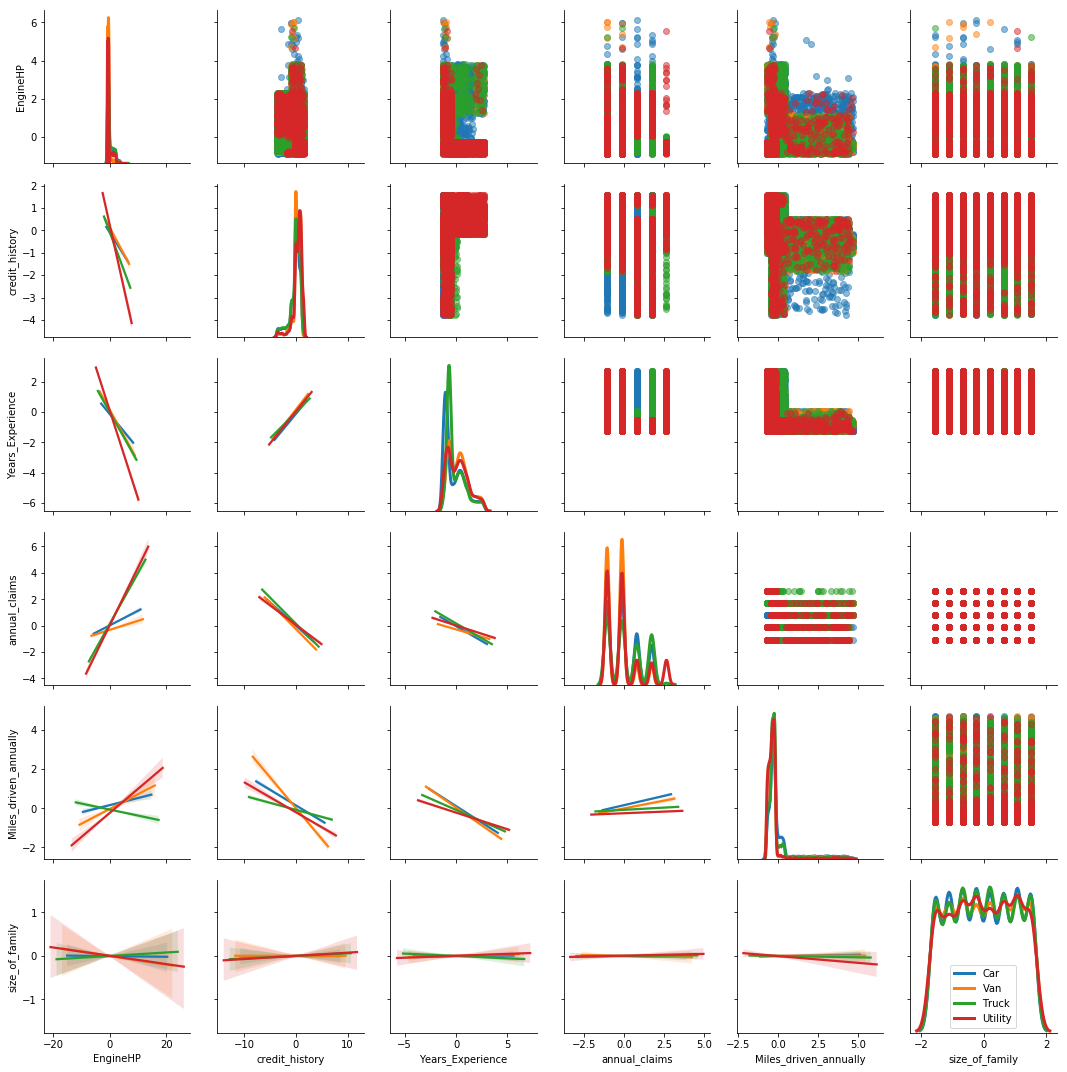

In [20]:
# Create a scatterplot matrix that shows all the bivariate relationships in one plot made up of subplots.
# Let us drop the 'target' variable

safe_driver_copy = safe_driver.drop(['target'], axis=1)

# Plot with the remaining feature set

g = sns.PairGrid(safe_driver_copy.dropna(), diag_sharey=False, hue='Vehicle_Type')
# As in the Unit 2 lesson example, create a Scatterplot in the top-right diagonal
g.map_upper(plt.scatter, alpha=.5)
# Linear relationship of two variables in the bottom-left diagonal
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# And...univariate distributions of the variables across the diagonal
g.map_diag(sns.kdeplot, lw=3)
plt.legend()
plt.show()

# The legend appears at the bottom-right plot


Our next step is to output a correlation heatmap that can tell us correlation coefficient of the features. If two variables are highly corrrelated our results could be incorrect or skewed.<br>
<br>
First we have to isolate the continuous variables in a dataframe before invoking the heatmap.<br>
<br>
Let us create the heatmap.

In [21]:
safe_driver_num_features = safe_driver.drop(['Gender', 'Marital_Status', 'Age_bucket', 'Vehicle_Type'], axis=1)

[]

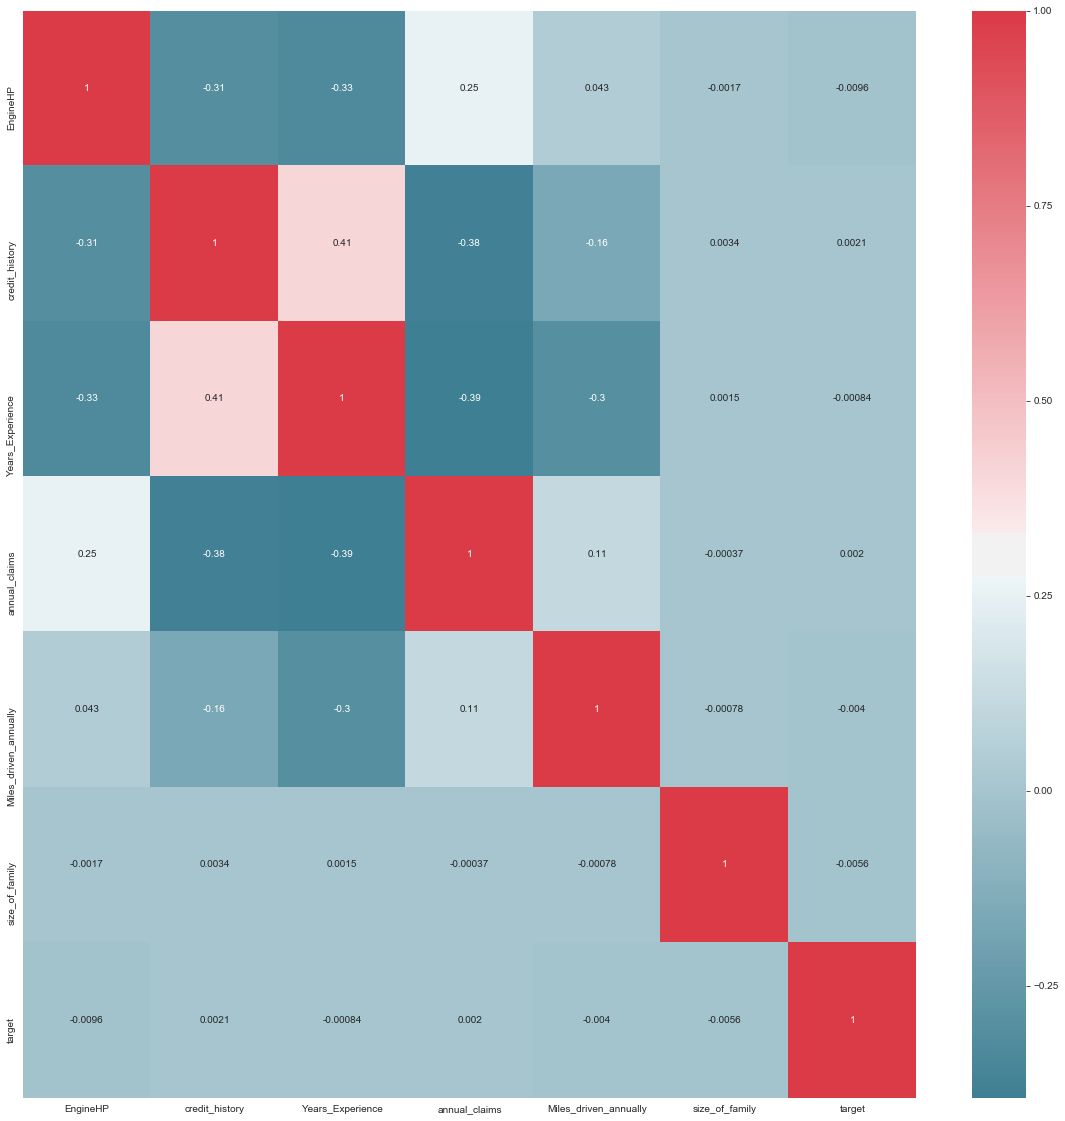

In [22]:
sns.set_style('white')
color_map = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(20, 20))
sns.heatmap(safe_driver_num_features.corr(), annot = True, cmap = color_map)
plt.plot()

Thankfully the variables are not highly correlated. We can keep the remaining features as it is.

Let us find out how significant are our features are in predicting our label. We will use the feature_importances_ method from the RandomForestClassifier. After that we plot the relative importance of the features using a barplot.<br>
<br>
Let us go ahead and select our categorical features, using a RandomForestClassifier.

Separate our feature set from the label (**'target'**) and convert all the categorial variables to numeric. Then split the feature set into training and test data sets.

In [23]:
safe_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 12 columns):
EngineHP                 30240 non-null float64
credit_history           30240 non-null float64
Years_Experience         30240 non-null float64
annual_claims            30240 non-null float64
Miles_driven_annually    30240 non-null float64
size_of_family           30240 non-null float64
target                   30240 non-null int64
Gender                   30240 non-null object
Marital_Status           30240 non-null object
Vehicle_Type             30240 non-null object
Age_bucket               30240 non-null object
State                    30240 non-null object
dtypes: float64(6), int64(1), object(5)
memory usage: 2.8+ MB


In [24]:
# Drop the 'target' column from training dataframe as that is our label
X = safe_driver.drop(['target'], 1)

# The 'target' column is our label or outcome that we want to predict
y = safe_driver['target']

# Use pd.dummies to resolve the categorical data (e.g. State) into numerical values
X = pd.get_dummies(X)

# Drop and NaN values
X = X.dropna(axis=1)

# Break the dataset into test and train with 2/3 (train) and 1/3 (test) split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [25]:
# Find out the feature importance using RandomForest

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=12)
regr.fit(X, y)

# The features identified by RandomForest will be our columns for the training and testing dataset

feature_importances = pd.DataFrame(regr.feature_importances_, index = X.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)

In [299]:
# Run LogisticRgression model on the training data set

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

y_predict = tree.predict(X_test)
tree.score(X_test, y_test) 

0.5789579158316633

In [301]:
# Print confusion matrix for DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predict)

array([[ 908, 1984],
       [2218, 4870]])

In [ ]:
# Our confusion matrix based on the DecisionTree does not look good. It is showing a high number of
# false positives and false negatives

In [302]:
# Run Support Vector Classifier to verify accuracy

from sklearn.svm import SVC
svc = SVC(gamma='auto')

svc.fit(X_train, y_train)

y_predict = svc.predict(X_train)

svc.score(X_train, y_train)

from sklearn.model_selection import cross_val_score
cross_val_score(svc, X_train, y_train, cv=5)

array([0.7061436 , 0.7061436 , 0.70631787, 0.70624537, 0.70624537])

In [308]:
pd.Series(y_predict).value_counts()

1    20260
dtype: int64

Though SVC returns better scores, all the predictions it made are of the success class only. This is worrisome

In [303]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_predict)

array([[    0,  5952],
       [    0, 14308]])

In [311]:
# Let us also run the SGDClassifier model to verify

from sklearn import linear_model
clf = linear_model.SGDClassifier(max_iter=10000, tol=1e-3)
clf.fit(X_train, y_train)

y_predict_SGD = clf.predict(X_train)

clf.score(X_train, y_train)

0.7062191510365252

In [312]:
confusion_matrix(y_train, y_predict_SGD)

array([[    0,  5952],
       [    0, 14308]])

SGD Classifier returns no true positives but only false positives and true negatives!

In [ ]:
from sklearn.model_selection import learning_curve, GridSearchCV
print("Fitting the classifier to the training set")
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']}
clf = GridSearchCV(SVC(class_weight='balanced'), param_grid)
clf = clf.fit(X_train, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change fro

Aborted GridSearchCV after more than a 10 hour run on a 30K+ row dataset!<br>
<br>
Trying SVC again with better tuning parameters found out from StackOverflow.

In [30]:
from sklearn.svm import SVC

classifier = SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

classifier = classifier.fit(X_train, y_train)

y_predict = classifier.predict(X_train)

In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_predict)

array([[3630, 2322],
       [7181, 7127]])